# 決策樹
參考資料 課本第5.08章

## a/分類  b/回歸  c/聚類（非監督） d/異常偵測

[維基百科](https://zh.wikipedia.org/wiki/%E5%86%B3%E7%AD%96%E6%A0%91)

## 決策樹型式
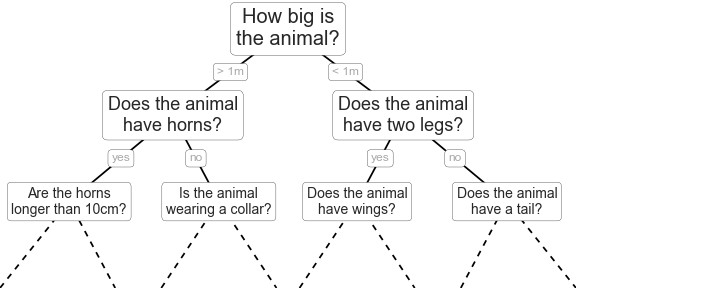

## 範例
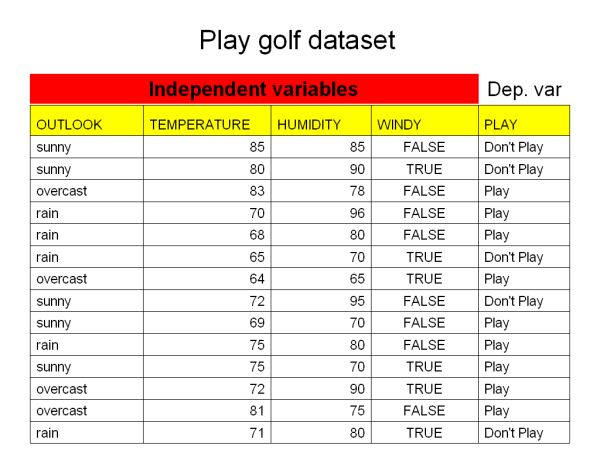
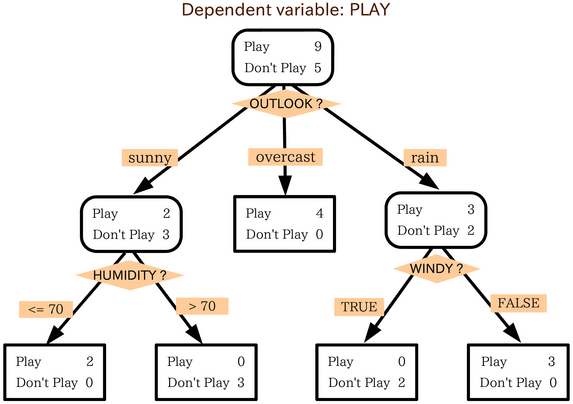

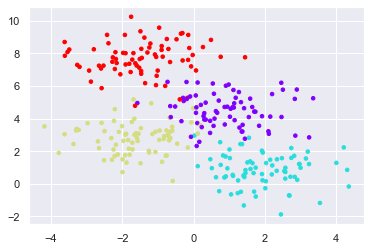

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# 產生範例資料
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

# 畫出點分布圖
# 參數可以參考 https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', marker ='.')

In [2]:
#建立決策樹的模組物件並用上面產生的資料來訓練
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [3]:
# 用來將訓練好的決策樹物件視覺化
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, marker ='.',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, #clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

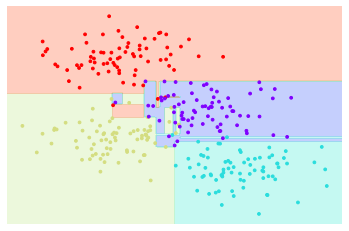

In [4]:
# 畫出決策樹的訓練結果
visualize_classifier(DecisionTreeClassifier(), X, y)

## Overfit
當決策樹的分類深度太深時會有過度學習的問題

In [5]:
# 測試不同的深度時，決策樹的學習狀況
# 需要使用 helpers_05_08.py
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=5), Ou…

## 使用多個決策樹
下面這兩張圖是將訓練資料分成兩半，各自訓練一半的結果：
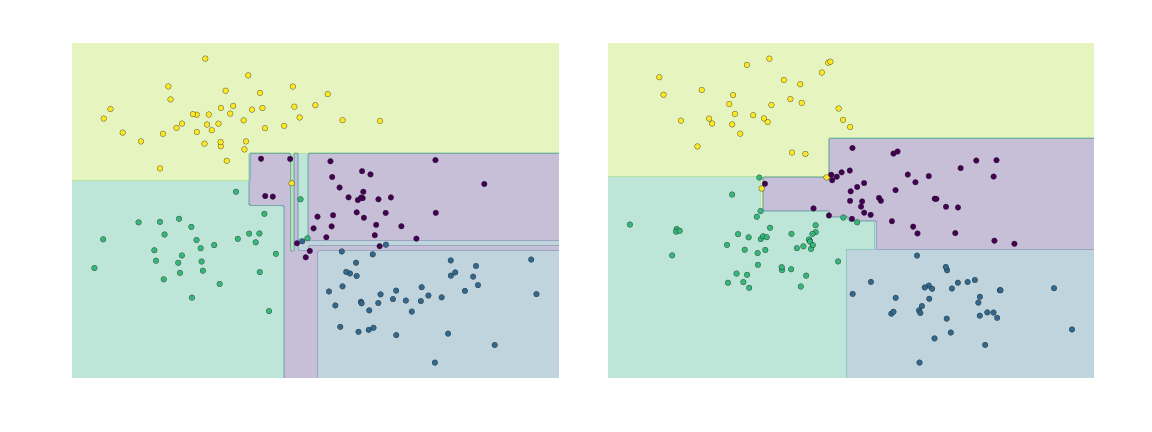
雖然一個決策樹容易有過度學習的問題，但是如果分別訓練兩個決策樹然後共同去做決策，可以減輕過度學習的問題。

In [6]:
# 不同數量的決策樹共同決策的結果
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 2, 5, 10, 20, 50, 75, 100), value=0), O…

## BaggingClassifier
BaggingClassifier可以重複建立許多同樣的分類器，但是每個分類器只隨機取部分的資料來訓練。最終一起進行決策。

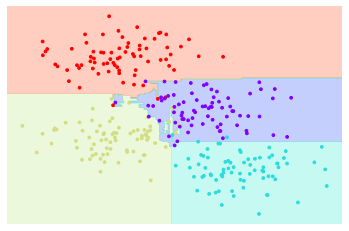

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

## Random-Forests
隨機生成樹即為決策樹的Bagging版本

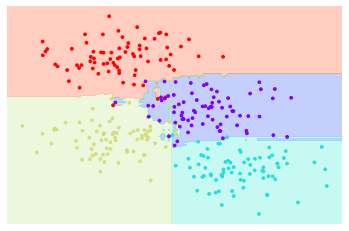

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## RandomForestRegressor
回歸版本的隨機生成樹

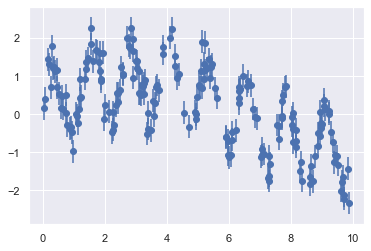

In [9]:
# 產生一個震盪起伏很大的回歸測試資料
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):   #產生測試資料
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

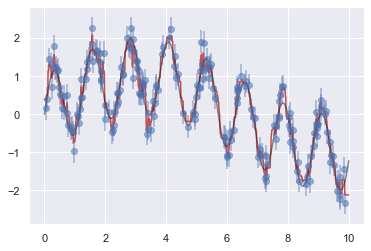

In [10]:
# 使用 RandomForestRegressor 的訓練結果
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)   #產生決策樹數
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

## 範例
將隨機生成樹應用在手寫數字辨識

In [37]:
# 載入手寫數字的訓練資料
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

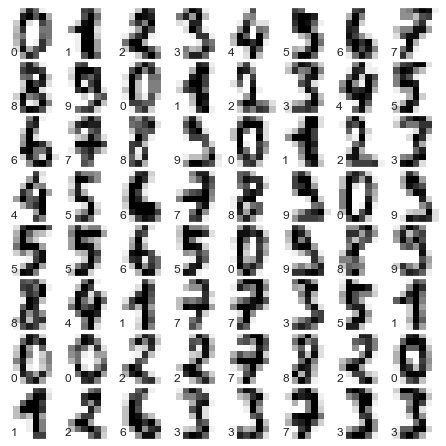

In [40]:
# 將部分的訓練資料畫出來
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [42]:
# 將資料分割成訓練跟測試兩個組別，然後用分別使用隨機生成樹進行訓練跟測試
from sklearn.model_selection  import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [43]:
# 訓練與測試的成果
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.96      0.96      0.96        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.96      0.97        48

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



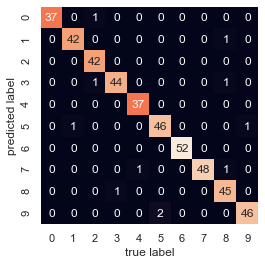

In [44]:
# 測試結果的方陣圖
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');